# SDXL

In [ ]:
import os
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from einops import rearrange, repeat
from pytorch_lightning import seed_everything

import copy
import math
import os
from glob import glob
from typing import Dict, List, Optional, Tuple, Union
import gc


import cv2
import imageio
import numpy as np
import streamlit as st
import torch
import torch.nn as nn
import torchvision.transforms as TT
from einops import rearrange, repeat
from omegaconf import ListConfig, OmegaConf
from PIL import Image
from safetensors.torch import load_file as load_safetensors
from scripts.demo.discretization import (
    Img2ImgDiscretizationWrapper,
    Txt2NoisyDiscretizationWrapper,
)
from scripts.util.detection.nsfw_and_watermark_dectection import DeepFloydDataFiltering
from sgm.inference.helpers import embed_watermark
from sgm.modules.diffusionmodules.guiders import (
    LinearPredictionGuider,
    TrianglePredictionGuider,
    VanillaCFG,
)
from sgm.modules.diffusionmodules.sampling import (
    DPMPP2MSampler,
    DPMPP2SAncestralSampler,
    EulerAncestralSampler,
    EulerEDMSampler,
    HeunEDMSampler,
    LinearMultistepSampler,
)
from sgm.util import append_dims, default, instantiate_from_config
from torch import autocast
from torchvision import transforms
from torchvision.utils import make_grid, save_image

/u/92/wenx2/unix/miniconda3/envs/diffusion/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/u/92/wenx2/unix/miniconda3/envs/diffusion/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/u/92/wenx2/unix/miniconda3/envs/diffusion/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and 

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


## Helper Functions

### Image

In [45]:
from IPython import display


def load_image(image_path, W, H):
    """Load and preprocess an image."""
    image = Image.open(image_path).convert("RGB")
    print(f"Loaded input image of size {image.size}")
    transform = transforms.Compose([
        transforms.Resize((H, W)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x * 2.0 - 1.0),
    ])
    return transform(image).unsqueeze(0).to(device)


In [ ]:
def load_img(
    img_path,
    size: Union[None, int, Tuple[int, int]] = None,
    center_crop: bool = False,
):
    image = Image.open(img_path)
    # display.display(image)

    w, h = image.size
    print(f"loaded input image of size ({w}, {h})")

    # Ensure target size is divisible by 64
    if size is not None:
        if isinstance(size, int):
            size = (size, size)
        size = (size[0] - size[0] % 64, size[1] - size[1] % 64)
        print(f"Adjusted size to be divisible by 64: {size}")

    transform = []
    if size is not None:
        transform.append(transforms.Resize(size))
    if center_crop:
        transform.append(transforms.CenterCrop(size))
    transform.append(transforms.ToTensor())
    transform.append(transforms.Lambda(lambda x: 2.0 * x - 1.0))

    transform = transforms.Compose(transform)
    img = transform(image)[None, ...].to(device)
    return img

### Embedder

In [5]:
def get_unique_embedder_keys_from_conditioner(conditioner):
    return list(set([x.input_key for x in conditioner.embedders]))

def init_embedder_options(keys, init_dict, prompt=None, negative_prompt=None):
    value_dict = {}
    for key in keys:
        if key == "txt":
            if prompt is None:
                prompt = "A professional photograph of an astronaut riding a pig"
            if negative_prompt is None:
                negative_prompt = ""

            prompt = st.text_input("Prompt", prompt)
            negative_prompt = st.text_input("Negative prompt", negative_prompt)

            value_dict["prompt"] = prompt
            value_dict["negative_prompt"] = negative_prompt

        if key == "original_size_as_tuple":
            orig_width = st.number_input(
                "orig_width",
                value=init_dict["orig_width"],
                min_value=16,
            )
            orig_height = st.number_input(
                "orig_height",
                value=init_dict["orig_height"],
                min_value=16,
            )

            value_dict["orig_width"] = orig_width
            value_dict["orig_height"] = orig_height

        if key == "crop_coords_top_left":
            crop_coord_top = st.number_input("crop_coords_top", value=0, min_value=0)
            crop_coord_left = st.number_input("crop_coords_left", value=0, min_value=0)

            value_dict["crop_coords_top"] = crop_coord_top
            value_dict["crop_coords_left"] = crop_coord_left

        if key == "aesthetic_score":
            value_dict["aesthetic_score"] = 6.0
            value_dict["negative_aesthetic_score"] = 2.5

        if key == "target_size_as_tuple":
            value_dict["target_width"] = init_dict["target_width"]
            value_dict["target_height"] = init_dict["target_height"]

        if key in ["fps_id", "fps"]:
            fps = st.number_input("fps", value=6, min_value=1)

            value_dict["fps"] = fps
            value_dict["fps_id"] = fps - 1

        if key == "motion_bucket_id":
            mb_id = st.number_input("motion bucket id", 0, 511, value=127)
            value_dict["motion_bucket_id"] = mb_id

        if key == "pool_image":
            st.text("Image for pool conditioning")
            image = load_img(
                key="pool_image_input",
                size=224,
                center_crop=True,
            )
            if image is None:
                st.info("Need an image here")
                image = torch.zeros(1, 3, 224, 224)
            value_dict["pool_image"] = image

    return value_dict

### Model

In [6]:
# Model configuration

VERSION2SPECS = {
    "SDXL-base-1.0": {
        "H": 1024,
        "W": 1024,
        "C": 4,
        "f": 8,
        "is_legacy": False,
        "config": "configs/inference/sd_xl_base.yaml",
        "ckpt": "checkpoints/sd_xl_base_1.0.safetensors",
    },
    "SDXL-base-0.9": {
        "H": 1024,
        "W": 1024,
        "C": 4,
        "f": 8,
        "is_legacy": False,
        "config": "configs/inference/sd_xl_base.yaml",
        "ckpt": "checkpoints/sd_xl_base_0.9.safetensors",
    },
    "SD-2.1": {
        "H": 512,
        "W": 512,
        "C": 4,
        "f": 8,
        "is_legacy": True,
        "config": "configs/inference/sd_2_1.yaml",
        "ckpt": "checkpoints/v2-1_512-ema-pruned.safetensors",
    },
    "SD-2.1-768": {
        "H": 768,
        "W": 768,
        "C": 4,
        "f": 8,
        "is_legacy": True,
        "config": "configs/inference/sd_2_1_768.yaml",
        "ckpt": "checkpoints/v2-1_768-ema-pruned.safetensors",
    },
    "SDXL-refiner-0.9": {
        "H": 1024,
        "W": 1024,
        "C": 4,
        "f": 8,
        "is_legacy": True,
        "config": "configs/inference/sd_xl_refiner.yaml",
        "ckpt": "checkpoints/sd_xl_refiner_0.9.safetensors",
    },
    "SDXL-refiner-1.0": {
        "H": 1024,
        "W": 1024,
        "C": 4,
        "f": 8,
        "is_legacy": True,
        "config": "configs/inference/sd_xl_refiner.yaml",
        "ckpt": "checkpoints/sd_xl_refiner_1.0.safetensors",
    },
}

In [7]:
lowvram_mode = True

def load_model(model):
    model.cuda()


def initial_model_load(model):
    if lowvram_mode:
        model.model.half()
    else:
        model.cuda()
    return model


def unload_model(model):
    if lowvram_mode:
        model.cpu()
        torch.cuda.empty_cache()


def load_model_from_config(config, ckpt=None, verbose=True):
    model = instantiate_from_config(config.model)

    if ckpt is not None:
        print(f"Loading model from {ckpt}")
        if ckpt.endswith("ckpt"):
            pl_sd = torch.load(ckpt, map_location="cpu")
            if "global_step" in pl_sd:
                global_step = pl_sd["global_step"]
                st.info(f"loaded ckpt from global step {global_step}")
                print(f"Global Step: {pl_sd['global_step']}")
            sd = pl_sd["state_dict"]
        elif ckpt.endswith("safetensors"):
            sd = load_safetensors(ckpt)
        else:
            raise NotImplementedError

        msg = None

        m, u = model.load_state_dict(sd, strict=False)

        if len(m) > 0 and verbose:
            print("missing keys:")
            print(m)
        if len(u) > 0 and verbose:
            print("unexpected keys:")
            print(u)
    else:
        msg = None

    model = initial_model_load(model)
    model.eval()
    return model, msg

### Sampling

In [8]:
def init_sampling(
    key=1,
    img2img_strength: Optional[float] = None,
    specify_num_samples: bool = True,
    stage2strength: Optional[float] = None,
    options: Optional[Dict[str, int]] = None,
):
    options = {} if options is None else options

    num_rows, num_cols = 1, 1
    if specify_num_samples:
        num_cols = st.number_input(
            f"num cols #{key}", value=num_cols, min_value=1, max_value=10
        )

    steps = st.number_input(
        f"steps #{key}", value=options.get("num_steps", 50), min_value=1, max_value=1000
    )
    sampler = ["EulerEDMSampler",
            "HeunEDMSampler",
            "EulerAncestralSampler",
            "DPMPP2SAncestralSampler",
            "DPMPP2MSampler",
            "LinearMultistepSampler",
        ][0]
        
    discretization = ["LegacyDDPMDiscretization",
            "EDMDiscretization"][0]

    discretization_config = get_discretization(discretization, options=options, key=key)

    guider_config = get_guider(options=options, key=key)

    sampler = get_sampler(sampler, steps, discretization_config, guider_config, key=key)
    if img2img_strength is not None:
        sampler.discretization = Img2ImgDiscretizationWrapper(
            sampler.discretization, strength=img2img_strength
        )
    if stage2strength is not None:
        sampler.discretization = Txt2NoisyDiscretizationWrapper(
            sampler.discretization, strength=stage2strength, original_steps=steps
        )
    return sampler, num_rows, num_cols


def get_discretization(discretization, options, key=1):
    if discretization == "LegacyDDPMDiscretization":
        discretization_config = {
            "target": "sgm.modules.diffusionmodules.discretizer.LegacyDDPMDiscretization",
        }
    elif discretization == "EDMDiscretization":
        sigma_min = st.sidebar.number_input(
            f"sigma_min #{key}", value=options.get("sigma_min", 0.03)
        )  # 0.0292
        sigma_max = st.sidebar.number_input(
            f"sigma_max #{key}", value=options.get("sigma_max", 14.61)
        )  # 14.6146
        rho = st.sidebar.number_input(f"rho #{key}", value=options.get("rho", 3.0))
        discretization_config = {
            "target": "sgm.modules.diffusionmodules.discretizer.EDMDiscretization",
            "params": {
                "sigma_min": sigma_min,
                "sigma_max": sigma_max,
                "rho": rho,
            },
        }

    return discretization_config


def get_sampler(sampler_name, steps, discretization_config, guider_config, key=1):
    if sampler_name == "EulerEDMSampler" or sampler_name == "HeunEDMSampler":
        s_churn = st.sidebar.number_input(f"s_churn #{key}", value=0.0, min_value=0.0)
        s_tmin = st.sidebar.number_input(f"s_tmin #{key}", value=0.0, min_value=0.0)
        s_tmax = st.sidebar.number_input(f"s_tmax #{key}", value=999.0, min_value=0.0)
        s_noise = st.sidebar.number_input(f"s_noise #{key}", value=1.0, min_value=0.0)

        if sampler_name == "EulerEDMSampler":
            sampler = EulerEDMSampler(
                num_steps=steps,
                discretization_config=discretization_config,
                guider_config=guider_config,
                s_churn=s_churn,
                s_tmin=s_tmin,
                s_tmax=s_tmax,
                s_noise=s_noise,
                verbose=True,
            )
        elif sampler_name == "HeunEDMSampler":
            sampler = HeunEDMSampler(
                num_steps=steps,
                discretization_config=discretization_config,
                guider_config=guider_config,
                s_churn=s_churn,
                s_tmin=s_tmin,
                s_tmax=s_tmax,
                s_noise=s_noise,
                verbose=True,
            )
    elif (
        sampler_name == "EulerAncestralSampler"
        or sampler_name == "DPMPP2SAncestralSampler"
    ):
        s_noise = st.sidebar.number_input("s_noise", value=1.0, min_value=0.0)
        eta = st.sidebar.number_input("eta", value=1.0, min_value=0.0)

        if sampler_name == "EulerAncestralSampler":
            sampler = EulerAncestralSampler(
                num_steps=steps,
                discretization_config=discretization_config,
                guider_config=guider_config,
                eta=eta,
                s_noise=s_noise,
                verbose=True,
            )
        elif sampler_name == "DPMPP2SAncestralSampler":
            sampler = DPMPP2SAncestralSampler(
                num_steps=steps,
                discretization_config=discretization_config,
                guider_config=guider_config,
                eta=eta,
                s_noise=s_noise,
                verbose=True,
            )
    elif sampler_name == "DPMPP2MSampler":
        sampler = DPMPP2MSampler(
            num_steps=steps,
            discretization_config=discretization_config,
            guider_config=guider_config,
            verbose=True,
        )
    elif sampler_name == "LinearMultistepSampler":
        order = st.sidebar.number_input("order", value=4, min_value=1)
        sampler = LinearMultistepSampler(
            num_steps=steps,
            discretization_config=discretization_config,
            guider_config=guider_config,
            order=order,
            verbose=True,
        )
    else:
        raise ValueError(f"unknown sampler {sampler_name}!")

    return sampler


def get_guider(options, key):
    guider = [
            "VanillaCFG",
            "IdentityGuider",
            "LinearPredictionGuider",
            "TrianglePredictionGuider",
        ][0]

    additional_guider_kwargs = options.pop("additional_guider_kwargs", {})

    if guider == "IdentityGuider":
        guider_config = {
            "target": "sgm.modules.diffusionmodules.guiders.IdentityGuider"
        }
    elif guider == "VanillaCFG":
        scale = st.number_input(
            f"cfg-scale #{key}",
            value=options.get("cfg", 5.0),
            min_value=0.0,
        )

        guider_config = {
            "target": "sgm.modules.diffusionmodules.guiders.VanillaCFG",
            "params": {
                "scale": scale,
                **additional_guider_kwargs,
            },
        }
    elif guider == "LinearPredictionGuider":
        max_scale = st.number_input(
            f"max-cfg-scale #{key}",
            value=options.get("cfg", 1.5),
            min_value=1.0,
        )
        min_scale = st.sidebar.number_input(
            f"min guidance scale",
            value=options.get("min_cfg", 1.0),
            min_value=1.0,
            max_value=10.0,
        )

        guider_config = {
            "target": "sgm.modules.diffusionmodules.guiders.LinearPredictionGuider",
            "params": {
                "max_scale": max_scale,
                "min_scale": min_scale,
                "num_frames": options["num_frames"],
                **additional_guider_kwargs,
            },
        }
    elif guider == "TrianglePredictionGuider":
        max_scale = st.number_input(
            f"max-cfg-scale #{key}",
            value=options.get("cfg", 2.5),
            min_value=1.0,
            max_value=10.0,
        )
        min_scale = st.sidebar.number_input(
            f"min guidance scale",
            value=options.get("min_cfg", 1.0),
            min_value=1.0,
            max_value=10.0,
        )

        guider_config = {
            "target": "sgm.modules.diffusionmodules.guiders.TrianglePredictionGuider",
            "params": {
                "max_scale": max_scale,
                "min_scale": min_scale,
                "num_frames": options["num_frames"],
                **additional_guider_kwargs,
            },
        }
    else:
        raise NotImplementedError
    return guider_config


def get_batch(
    keys,
    value_dict: dict,
    N: Union[List, ListConfig],
    device: str = "cuda",
    T: int = None,
    additional_batch_uc_fields: List[str] = [],
):
    # Hardcoded demo setups; might undergo some changes in the future

    batch = {}
    batch_uc = {}

    for key in keys:
        if key == "txt":
            batch["txt"] = [value_dict["prompt"]] * math.prod(N)

            batch_uc["txt"] = [value_dict["negative_prompt"]] * math.prod(N)

        elif key == "original_size_as_tuple":
            batch["original_size_as_tuple"] = (
                torch.tensor([value_dict["orig_height"], value_dict["orig_width"]])
                .to(device)
                .repeat(math.prod(N), 1)
            )
        elif key == "crop_coords_top_left":
            batch["crop_coords_top_left"] = (
                torch.tensor(
                    [value_dict["crop_coords_top"], value_dict["crop_coords_left"]]
                )
                .to(device)
                .repeat(math.prod(N), 1)
            )
        elif key == "aesthetic_score":
            batch["aesthetic_score"] = (
                torch.tensor([value_dict["aesthetic_score"]])
                .to(device)
                .repeat(math.prod(N), 1)
            )
            batch_uc["aesthetic_score"] = (
                torch.tensor([value_dict["negative_aesthetic_score"]])
                .to(device)
                .repeat(math.prod(N), 1)
            )

        elif key == "target_size_as_tuple":
            batch["target_size_as_tuple"] = (
                torch.tensor([value_dict["target_height"], value_dict["target_width"]])
                .to(device)
                .repeat(math.prod(N), 1)
            )
        elif key == "fps":
            batch[key] = (
                torch.tensor([value_dict["fps"]]).to(device).repeat(math.prod(N))
            )
        elif key == "fps_id":
            batch[key] = (
                torch.tensor([value_dict["fps_id"]]).to(device).repeat(math.prod(N))
            )
        elif key == "motion_bucket_id":
            batch[key] = (
                torch.tensor([value_dict["motion_bucket_id"]])
                .to(device)
                .repeat(math.prod(N))
            )
        elif key == "pool_image":
            batch[key] = repeat(value_dict[key], "1 ... -> b ...", b=math.prod(N)).to(
                device, dtype=torch.half
            )
        elif key == "cond_aug":
            batch[key] = repeat(
                torch.tensor([value_dict["cond_aug"]]).to("cuda"),
                "1 -> b",
                b=math.prod(N),
            )
        elif key == "cond_frames":
            batch[key] = repeat(value_dict["cond_frames"], "1 ... -> b ...", b=N[0])
        elif key == "cond_frames_without_noise":
            batch[key] = repeat(
                value_dict["cond_frames_without_noise"], "1 ... -> b ...", b=N[0]
            )
        elif key == "polars_rad":
            batch[key] = torch.tensor(value_dict["polars_rad"]).to(device).repeat(N[0])
        elif key == "azimuths_rad":
            batch[key] = (
                torch.tensor(value_dict["azimuths_rad"]).to(device).repeat(N[0])
            )
        else:
            batch[key] = value_dict[key]

    if T is not None:
        batch["num_video_frames"] = T

    for key in batch.keys():
        if key not in batch_uc and isinstance(batch[key], torch.Tensor):
            batch_uc[key] = torch.clone(batch[key])
        elif key in additional_batch_uc_fields and key not in batch_uc:
            batch_uc[key] = copy.copy(batch[key])
    return batch, batch_uc

In [47]:
@torch.no_grad()
def do_img2img(
    img,
    model,
    sampler,
    value_dict,
    num_samples,
    force_uc_zero_embeddings: Optional[List] = None,
    force_cond_zero_embeddings: Optional[List] = None,
    additional_kwargs={},
    offset_noise_level: int = 0.0,
    return_latents=False,
    skip_encode=False,
    filter=None,
    add_noise=True,
):
    precision_scope = autocast
    with torch.no_grad():
        with precision_scope("cuda"):
            with model.ema_scope():
                load_model(model.conditioner)
                batch, batch_uc = get_batch(
                    get_unique_embedder_keys_from_conditioner(model.conditioner),
                    value_dict,
                    [num_samples],
                )
                c, uc = model.conditioner.get_unconditional_conditioning(
                    batch,
                    batch_uc=batch_uc,
                    force_uc_zero_embeddings=force_uc_zero_embeddings,
                    force_cond_zero_embeddings=force_cond_zero_embeddings,
                )
                unload_model(model.conditioner)
                for k in c:
                    c[k], uc[k] = map(lambda y: y[k][:num_samples].to("cuda"), (c, uc))

                for k in additional_kwargs:
                    c[k] = uc[k] = additional_kwargs[k]
                if skip_encode:
                    z = img
                else:
                    load_model(model.first_stage_model)
                    z = model.encode_first_stage(img)
                    unload_model(model.first_stage_model)

                noise = torch.randn_like(z)

                sigmas = sampler.discretization(sampler.num_steps).cuda()
                sigma = sigmas[0]

                st.info(f"all sigmas: {sigmas}")
                st.info(f"noising sigma: {sigma}")
                if offset_noise_level > 0.0:
                    noise = noise + offset_noise_level * append_dims(
                        torch.randn(z.shape[0], device=z.device), z.ndim
                    )
                if add_noise:
                    noised_z = z + noise * append_dims(sigma, z.ndim).cuda()
                    noised_z = noised_z / torch.sqrt(
                        1.0 + sigmas[0] ** 2.0
                    )  # Note: hardcoded to DDPM-like scaling. need to generalize later.
                else:
                    noised_z = z / torch.sqrt(1.0 + sigmas[0] ** 2.0)

                def denoiser(x, sigma, c):
                    return model.denoiser(model.model, x, sigma, c)

                load_model(model.denoiser)
                load_model(model.model)
                samples_z = sampler(denoiser, noised_z, cond=c, uc=uc)
                unload_model(model.model)
                unload_model(model.denoiser)

                load_model(model.first_stage_model)
                samples_x = model.decode_first_stage(samples_z)
                unload_model(model.first_stage_model)
                samples = torch.clamp((samples_x + 1.0) / 2.0, min=0.0, max=1.0)

                if filter is not None:
                    samples = filter(samples)

                grid = torch.stack([samples]) 
                grid = rearrange(grid, "n b c h w -> (n h) (b w) c")
                if return_latents:
                    return samples, samples_z
                return samples

In [30]:

@torch.no_grad()
def run_img2img(
    model,
    prompt_dict,
    is_legacy=False,
    return_latents=False,
    filter=None,
):
    img = load_img(prompt_dict["img_path"], prompt_dict["resolution"])

    H, W = img.shape[2], img.shape[3]

    init_dict = {
        "orig_width": W,
        "orig_height": H,
        "target_width": W,
        "target_height": H,
    }

    print(init_dict)

    value_dict = init_embedder_options(
        get_unique_embedder_keys_from_conditioner(model.conditioner),
        init_dict,
        prompt=prompt_dict["prompt"],
        negative_prompt=prompt_dict["negative_prompt"],
    )

    sampler, num_rows, num_cols = init_sampling(
        img2img_strength=prompt_dict["strength"],
        stage2strength=prompt_dict["stage2strength"],
    )
    num_samples = num_rows * num_cols

    out = do_img2img(
        repeat(img, "1 ... -> n ...", n=num_samples),
        model,
        sampler,
        value_dict,
        num_samples,
        force_uc_zero_embeddings=["txt"] if not is_legacy else [],
        return_latents=return_latents,
        filter=filter,
    )
    
    return out

## Run

In [65]:
import warnings

warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [12]:
lowvram_mode = True

def init(version_dict, load_ckpt=True, load_filter=True):
    # state = dict()
    config = version_dict["config"]
    ckpt = version_dict["ckpt"]

    config = OmegaConf.load(config)
    model, msg = load_model_from_config(config, ckpt if load_ckpt else None)

    print(msg)
    # state["model"] = model
    # state["ckpt"] = ckpt if load_ckpt else None
    # state["config"] = config
    filters = None
    if load_filter:
        filters = DeepFloydDataFiltering(verbose=False)

    return model, filters

In [13]:
# Configuration Parameters
MODEL_VERSION = "SDXL-refiner-1.0"  # Set model version
PROMPT = "Painting in Monet's style, muted colors, Impressionistic strokes, detailed, 8k"
NEGATIVE_PROMPT = ""
# MODE = "img2img"  # Choose between 'txt2img' and 'img2img'
SEED = 42  # Set seed for reproducibility
SAVE_PATH = "outputs/demo/img2img/"
# RESOLUTION = (1024, 1024)  # Width, Height
LOW_VRAM_MODE = True

# Initialize
seed_everything(SEED)
os.makedirs(SAVE_PATH, exist_ok=True)

# Model and Sampler Initialization (assumes helper functions are imported)
version_dict = VERSION2SPECS[MODEL_VERSION]
is_legacy = version_dict["is_legacy"]
model, filters = init(version_dict)
load_model(model)

Global seed set to 42
SpatialTransformer: Found context dims [1280] of depth 1, which does not match the specified 'depth' of 4. Setting context_dim to [1280, 1280, 1280, 1280] now.
SpatialTransformer: Found context dims [1280] of depth 1, which does not match the specified 'depth' of 4. Setting context_dim to [1280, 1280, 1280, 1280] now.
SpatialTransformer: Found context dims [1280] of depth 1, which does not match the specified 'depth' of 4. Setting context_dim to [1280, 1280, 1280, 1280] now.
SpatialTransformer: Found context dims [1280] of depth 1, which does not match the specified 'depth' of 4. Setting context_dim to [1280, 1280, 1280, 1280] now.
SpatialTransformer: Found context dims [1280] of depth 1, which does not match the specified 'depth' of 4. Setting context_dim to [1280, 1280, 1280, 1280] now.
SpatialTransformer: Found context dims [1280] of depth 1, which does not match the specified 'depth' of 4. Setting context_dim to [1280, 1280, 1280, 1280] now.
SpatialTransformer

Initialized embedder #0: FrozenOpenCLIPEmbedder2 with 694659841 params. Trainable: False
Initialized embedder #1: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #2: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #3: ConcatTimestepEmbedderND with 0 params. Trainable: False
Loading model from checkpoints/sd_xl_refiner_1.0.safetensors
missing keys:
['denoiser.sigmas']
None


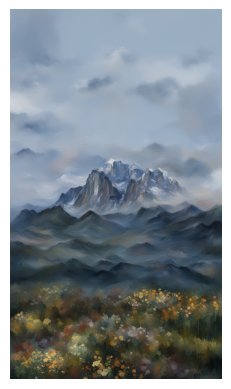

In [ ]:
img_dir = "../CLIP-Guided/prompts/imgs"

prompt_dict = {
    "img_path": os.path.join(img_dir, "Mountain, Sichuan.JPEG"),
    "resolution": (1400, 800), # H, W
    # "resolution": (1152, 1792), # W, H
    # "prompt": "Painting in Monet's style, muted colors, Impressionistic strokes, detailed, 8k",
    "prompt": "Painting of autumn in Monet's style, muted colors, Impressionistic strokes, detailed, 8k",
    "negative_prompt": "",
    "strength": 0.45,      # img2img strength
    "stage2strength": None,
    # "stage2strength": 0.15,
}

unload_model(model)
torch.cuda.empty_cache()
gc.collect()

seed_everything(SEED)

samples = run_img2img(model, prompt_dict, is_legacy, False, filters)

# Save Output
for i, sample in enumerate(samples):
    sample = (255.0 * rearrange(sample.cpu().numpy(), "c h w -> h w c")).astype(np.uint8)
    
    # Construct initial output path
    base_filename = os.path.basename(prompt_dict["img_path"]).split(".")[0]
    output_path = os.path.join(SAVE_PATH, f"{base_filename}_{i:03}.png")
    
    # Check if file exists, and increment 'i' if necessary
    while os.path.exists(output_path):
        i += 1
        output_path = os.path.join(SAVE_PATH, f"{base_filename}_{i:03}.png")
    
    # Save the image to the unique path
    Image.fromarray(sample).save(output_path)
    print(f"Saved image to {output_path}")

    display.clear_output(wait=True)

    # Load the image
    img = mpimg.imread(output_path)

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    # display.clear_output(wait=True)
    # display.Image(output_path)

In [ ]:
print(torch.cuda.memory_summary(device="cuda"))

In [ ]:

# List all tensors consuming GPU memory
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, "data") and torch.is_tensor(obj.data)):
            if obj.is_cuda:
                print(f"Tensor: {type(obj)}, Shape: {obj.size()}, Device: {obj.device}")
    except Exception as e:
        pass